## **4.01. Construcción de Modelos** (entrenamiento)

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import lightgbm as lgb
# Si se usa colab hay que instalar catboost
try:
    import catboost as cat
except Exception:
    !pip install catboost
finally:
    import catboost as cat

try:
    import optuna
except Exception:
    !pip install optuna
finally:
    import optuna

# import tensorflow as tf
import seaborn as sns
from joblib import dump, load
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.ensemble import VotingClassifier, VotingRegressor
from sklearn.metrics import r2_score, mean_squared_error, accuracy_score

import warnings; warnings.filterwarnings("ignore")
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 500)

In [3]:
# CARGA DE DATOS POST ANALISIS
df = pd.read_csv('ale_traffic_site.csv')

---

In [6]:
df.nunique()

visitNumber                          50
hits                                 96
transactionRevenue                  147
visitStartTime_month                 12
visitStartTime_day                   31
channelGrouping_Affiliates            2
channelGrouping_Direct                2
channelGrouping_Display               2
channelGrouping_Organic Search        2
channelGrouping_Paid Search           2
channelGrouping_Referral              2
channelGrouping_Social                2
operatingSystem_Android               2
operatingSystem_BlackBerry            2
operatingSystem_Chrome OS             2
operatingSystem_Firefox OS            2
operatingSystem_Linux                 2
operatingSystem_Macintosh             2
operatingSystem_Nintendo WiiU         2
operatingSystem_Samsung               2
operatingSystem_Windows               2
operatingSystem_Windows Phone         2
operatingSystem_iOS                   2
deviceCategory_mobile                 2
deviceCategory_tablet                 2


In [ ]:
# Tratamiento de datos adicional, estandarizando las variables numericas con z-score
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

num_cols = ['visitNumber', 'hits', 'visitStartTime_month', 'visitStartTime_day']
df[num_cols] = scaler.fit_transform(df[num_cols])

---

### Configuramos Optuna

In [ ]:
def optuna_search(model, param_space, X_train, y_train, scoring='neg_root_mean_squared_error', n_iter=10, cv=5):
    """
    Performs hyperparameter tuning using Optuna.

    Parameters:
        model: The estimator of the model you want to tune.
        param_space: A dictionary with hyperparameter names and their search spaces.
        X_train: Training feature set.
        y_train: Labels of the training set.
        scoring: The evaluation metric. Default is 'accuracy'.
        n_iter: Number of Optuna trials. Default is 10.
        cv: Number of cross-validation partitions. Default is 5.

    Returns:
        optuna.study.Study: The Optuna study object.
    """

    def objective(trial):
        # Define hyperparameters to be optimized
        params = {}
        for param_name, param_range in param_space.items():
            if isinstance(param_range, list):
                # If they are categorical values, use suggest_categorical
                params[param_name] = trial.suggest_categorical(param_name, param_range)
            elif isinstance(param_range, tuple) and len(param_range) == 2:
                lower, upper = param_range
                if isinstance(lower, int) and isinstance(upper, int):
                    # If it is a range of integers, use suggest_int
                    params[param_name] = trial.suggest_int(param_name, lower, upper)
                elif isinstance(lower, float) and isinstance(upper, float):
                    # If it is a range of floats, use suggest_uniform
                    params[param_name] = trial.suggest_discrete_uniform(param_name, lower, upper, 0.02)
                else:
                    raise ValueError(f"Unsupported range type for hyperparameter {param_name}")
            else:
                raise ValueError(f"Invalid range for hyperparameter {param_name}")

        # Set the hyperparameters in the model
        model.set_params(**params)

        # Perform cross-validation
        scores = cross_val_score(model, X_train, y_train, cv=cv, scoring=scoring)
        score = scores.mean()

        return score

    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=n_iter)

    return study

### R2 Ajustado

In [ ]:
# Definimos R2 ajustado
def r2_adj(df, y_true, y_pred):
    n = len(y_true)
    p = len(df.columns)
    r2 = r2_score(y_true, y_pred)
    return 1 - (1 - r2) * (n - 1) / (n - p - 1)

### Modelo LGBM

In [ ]:
data = df.copy()

In [ ]:
def lbgclass(seed=42, data=data, n_iter=10, cv=5):
        # Clasificador
        clf_lgb = lgb.LGBMClassifier(random_state=seed, n_jobs=-1, verbosity=-1)

        # Dividimos en entrenamiento y prueba
        X = data.drop('transactionRevenue', axis=1)
        y = data['transactionRevenue'].apply(lambda x: 1 if x > 0 else 0)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


        # Creamos un random search para encontrar los mejores hiperparámetros
        params = {
                'boosting_type': ['gbdt', 'dart', 'rf'], # 'goss'
                'max_depth': (3, 10),
                'learning_rate': (0.01, 0.2),
                'n_estimators': (100, 1000),
                'subsample': (0.5, 1.0),
                'colsample_bytree': (0.5, 1.0),
                'reg_alpha': (0.0, 1.0),
                'reg_lambda': (0.0, 1.0),
                'min_child_weight': (1, 10),
                'num_leaves': (31, 256),
                'min_child_samples': (5, 100),
                'min_split_gain': (0.0, 0.5),
                'subsample_freq': (0, 10),
                'feature_fraction': (0.5, 1.0),
                'bagging_fraction': (0.5, 1.0),
                'bagging_freq': (1, 10),
                }

        # Obtenemos los mejores hiperparámetros
        search = optuna_search(
                model=clf_lgb,
                param_space=params,
                X_train=X_train, y_train=y_train,
                scoring='accuracy',
                cv=cv,
                n_iter=n_iter)
        best_params = search.best_params

        # Entrenamos el clasificador
        clf_lgb = lgb.LGBMClassifier(**best_params, random_state=seed, n_jobs=-1, verbosity=-1)
        clf_lgb.fit(X_train, y_train, eval_set=[(X_test, y_test)])

        # Predecimos con el clasificador
        y_pred_cls_lgb = clf_lgb.predict(X_test)

        # Score del clasificador
        print(f'Precisión del clasificador: {accuracy_score(y_test, y_pred_cls_lgb):.3f}')

        return clf_lgb

In [ ]:
clf_lgb = lbgclass(n_iter=10)

[I 2024-03-16 01:31:52,205] A new study created in memory with name: no-name-c4bdec6e-d88c-4570-8268-5b888b9cbdec
[I 2024-03-16 01:31:57,956] Trial 0 finished with value: 0.9859558033645769 and parameters: {'boosting_type': 'gbdt', 'max_depth': 5, 'learning_rate': 0.01, 'n_estimators': 910, 'subsample': 0.78, 'colsample_bytree': 0.58, 'reg_alpha': 0.6, 'reg_lambda': 0.28, 'min_child_weight': 3, 'num_leaves': 166, 'min_child_samples': 63, 'min_split_gain': 0.1, 'subsample_freq': 10, 'feature_fraction': 0.52, 'bagging_fraction': 0.9199999999999999, 'bagging_freq': 1}. Best is trial 0 with value: 0.9859558033645769.
[I 2024-03-16 01:32:10,840] Trial 1 finished with value: 0.9722160183682398 and parameters: {'boosting_type': 'dart', 'max_depth': 6, 'learning_rate': 0.09, 'n_estimators': 456, 'subsample': 0.6799999999999999, 'colsample_bytree': 0.6, 'reg_alpha': 0.02, 'reg_lambda': 0.64, 'min_child_weight': 5, 'num_leaves': 119, 'min_child_samples': 68, 'min_split_gain': 0.02, 'subsample_fr

Precisión del clasificador: 0.986


In [ ]:
def lgbreg(seed=42, data=data, n_iter=10, cv=5):
        # Regresor
        reg_lgb = lgb.LGBMRegressor(random_state=seed, n_jobs=-1, verbosity=-1)

        # Agregamos la columna 'class' y dividimos en entrenamiento y prueba
        data['class'] = clf_lgb.predict(data.drop(columns=['transactionRevenue']))
        X = data.drop(columns=['transactionRevenue'])
        y = data['transactionRevenue']
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=42)

        # Creamos un random search para encontrar los mejores hiperparámetros
        params = {
                'boosting_type': ['gbdt', 'dart', 'rf'], # 'goss'
                'max_depth': (3, 10),
                'learning_rate': (0.01, 0.2),
                'n_estimators': (100, 1000),
                'subsample': (0.5, 1.0),
                'colsample_bytree': (0.5, 1.0),
                'reg_alpha': (0.0, 1.0),
                'reg_lambda': (0.0, 1.0),
                'min_child_weight': (1, 10),
                'num_leaves': (31, 256),
                'min_child_samples': (5, 100),
                'min_split_gain': (0.0, 0.5),
                'subsample_freq': (0, 10),
                'feature_fraction': (0.5, 1.0),
                'bagging_fraction': (0.5, 1.0),
                'bagging_freq': (1, 10),
                }

        # Obtenemos los mejores hiperparámetros
        search = optuna_search(
                model=reg_lgb,
                param_space=params,
                X_train=X_train, y_train=y_train,
                scoring='neg_mean_squared_error',
                cv=cv,
                n_iter=n_iter)
        best_params = search.best_params

        # Entrenamos el regresor
        reg_lgb = lgb.LGBMRegressor(**best_params, random_state=seed, n_jobs=-1, verbosity=-1)
        reg_lgb.fit(X_train, y_train, eval_set=[(X_test, y_test)])

        # Predecimos con el regresor
        y_pred_reg_lgb = reg_lgb.predict(X_test)

        # Convertimos todas las predicciones menores a 0.01 en 0
        y_pred_reg_lgb = np.where(y_pred_reg_lgb < 0.01, 0, y_pred_reg_lgb)

        # Score del regresor para rmse
        print(f'Raiz del error para el regresor: {np.sqrt(mean_squared_error(y_test, y_pred_reg_lgb)):.3f}')

        return reg_lgb, y_pred_reg_lgb, np.sqrt(mean_squared_error(y_test, y_pred_reg_lgb)), r2_adj(X_test, y_test, y_pred_reg_lgb)

In [ ]:
reg_lgb, reg_lgb_pred, lgb_rmse, lgb_r2_adj = lgbreg(n_iter=10)

[I 2024-03-16 01:32:24,417] A new study created in memory with name: no-name-e00707ac-a8eb-4240-ac5b-c98d572eb311
[I 2024-03-16 01:32:28,067] Trial 0 finished with value: -419.8580481444951 and parameters: {'boosting_type': 'gbdt', 'max_depth': 5, 'learning_rate': 0.03, 'n_estimators': 711, 'subsample': 0.9199999999999999, 'colsample_bytree': 0.88, 'reg_alpha': 0.44, 'reg_lambda': 0.54, 'min_child_weight': 9, 'num_leaves': 125, 'min_child_samples': 34, 'min_split_gain': 0.12, 'subsample_freq': 0, 'feature_fraction': 0.8200000000000001, 'bagging_fraction': 0.74, 'bagging_freq': 6}. Best is trial 0 with value: -419.8580481444951.
[I 2024-03-16 01:34:43,695] Trial 1 finished with value: -422.05485629987925 and parameters: {'boosting_type': 'dart', 'max_depth': 10, 'learning_rate': 0.11, 'n_estimators': 861, 'subsample': 0.9199999999999999, 'colsample_bytree': 0.88, 'reg_alpha': 0.0, 'reg_lambda': 0.76, 'min_child_weight': 1, 'num_leaves': 163, 'min_child_samples': 55, 'min_split_gain': 0.

Raiz del error para el regresor: 16.048


<Axes: >

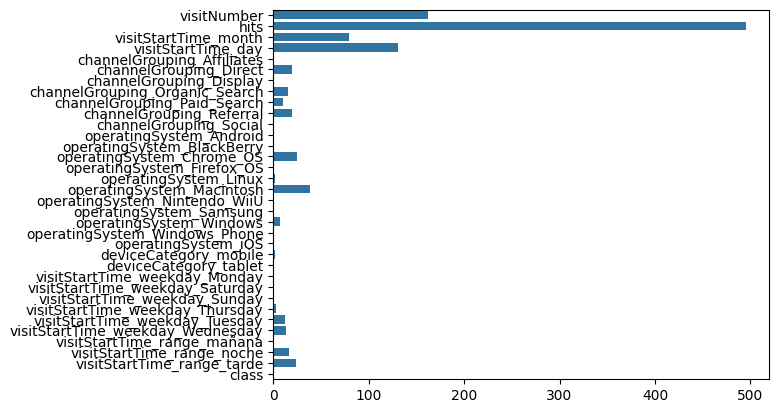

In [ ]:
# feature importance
sns.barplot(x = list(reg_lgb.feature_importances_), y = list(reg_lgb.feature_name_))

In [ ]:
print('Resultados:')

print(f'Los hiperparámetros son: {reg_lgb.get_params()}')
print(f'El rmse es: {lgb_rmse:.2f}')
print(f'El r2 es: {lgb_r2_adj:.2f}')

Resultados:
Los hiperparámetros son: {'boosting_type': 'gbdt', 'class_weight': None, 'colsample_bytree': 0.58, 'importance_type': 'split', 'learning_rate': 0.19, 'max_depth': 6, 'min_child_samples': 77, 'min_child_weight': 1, 'min_split_gain': 0.12, 'n_estimators': 108, 'n_jobs': -1, 'num_leaves': 216, 'objective': None, 'random_state': 42, 'reg_alpha': 0.16, 'reg_lambda': 0.9, 'subsample': 0.58, 'subsample_for_bin': 200000, 'subsample_freq': 1, 'feature_fraction': 0.96, 'bagging_fraction': 0.64, 'bagging_freq': 8, 'verbosity': -1}
El rmse es: 16.05
El r2 es: 0.07


In [ ]:
# # Guardamos el modelo LGBM
# dump(clf_lgb, 'clasificador_lgb.joblib')
# dump(reg_lgb, 'regresor_lgb.joblib')

In [ ]:
# INGENIERIA
# dejaré solo las variables que aportan valor


### Modelo CatBoost

In [ ]:
data = df.copy()

In [ ]:
def catclass(seed=42, data=data, n_iter=10, cv=5):
        # Clasificador
        clf_cat = cat.CatBoostClassifier(random_state=seed, verbose=0)

        # Dividimos en entrenamiento y prueba
        X = data.drop('transactionRevenue', axis=1)
        y = data['transactionRevenue'].apply(lambda x: 1 if x > 0 else 0)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

        # Creamos un random search para encontrar los mejores hiperparámetros
        params = {
                'depth': (3, 10),
                'learning_rate': (0.01, 0.2),
                'n_estimators': (100, 1000),
                'l2_leaf_reg': (0.0, 1.0),
                'border_count': (32, 255),
                'thread_count': (1, 10),
                'random_strength': (0.0, 1.0),
                'bagging_temperature': (0.0, 1.0),
                'max_ctr_complexity': (1, 5),
                }

        # Obtenemos los mejores hiperparámetros
        search = optuna_search(
                model=clf_cat,
                param_space=params,
                X_train=X_train, y_train=y_train,
                scoring='accuracy',
                cv=5,
                n_iter=20)
        best_params = search.best_params

        # Entrenamos el clasificador
        clf_cat = cat.CatBoostClassifier(**best_params, verbose=0, random_state=seed)
        clf_cat.fit(X_train, y_train, eval_set=(X_test, y_test), early_stopping_rounds=20)

        # Predecimos con el clasificador
        y_pred_cls_lgb = clf_cat.predict(X_test)

        # Score del clasificador
        print(f'Precisión del clasificador: {accuracy_score(y_test, y_pred_cls_lgb):.3f}')

        return clf_cat

In [ ]:
clf_cat = catclass()

[I 2024-03-16 01:39:29,339] A new study created in memory with name: no-name-8b6594a8-155b-4986-936d-6061cc086b3e
[I 2024-03-16 01:39:53,665] Trial 0 finished with value: 0.9842597780256073 and parameters: {'depth': 10, 'learning_rate': 0.15000000000000002, 'n_estimators': 706, 'l2_leaf_reg': 0.84, 'border_count': 126, 'thread_count': 4, 'random_strength': 0.58, 'bagging_temperature': 0.88, 'max_ctr_complexity': 2}. Best is trial 0 with value: 0.9842597780256073.
[I 2024-03-16 01:40:03,256] Trial 1 finished with value: 0.9849111849101245 and parameters: {'depth': 9, 'learning_rate': 0.19, 'n_estimators': 404, 'l2_leaf_reg': 0.2, 'border_count': 113, 'thread_count': 2, 'random_strength': 0.66, 'bagging_temperature': 0.76, 'max_ctr_complexity': 2}. Best is trial 1 with value: 0.9849111849101245.
[I 2024-03-16 01:40:29,948] Trial 2 finished with value: 0.9853452597880409 and parameters: {'depth': 10, 'learning_rate': 0.05, 'n_estimators': 752, 'l2_leaf_reg': 0.28, 'border_count': 74, 'thr

Precisión del clasificador: 0.987


In [ ]:
def catreg(seed=42, data=data, n_iter=10, cv=5):
        # Regresor
        reg_cat = cat.CatBoostRegressor(random_state=seed, verbose=0)

        # Agregamos la columna 'class' y dividimos en entrenamiento y prueba
        data['class'] = clf_cat.predict(data.drop(columns=['transactionRevenue']))
        X = data.drop(columns=['transactionRevenue'])
        y = data['transactionRevenue']
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

        # Creamos un random search para encontrar los mejores hiperparámetros
        params = {
                'depth': (3, 10),
                'learning_rate': (0.01, 0.2),
                'n_estimators': (100, 1000),
                'l2_leaf_reg': (0.0, 1.0),
                'border_count': (32, 255),
                'thread_count': (1, 10),
                'random_strength': (0.0, 1.0),
                'bagging_temperature': (0.0, 1.0),
                'max_ctr_complexity': (1, 5),
                }

        # Obtenemos los mejores hiperparámetros
        search = optuna_search(
                model=reg_cat,
                param_space=params,
                X_train=X_train, y_train=y_train,
                scoring='neg_mean_squared_error',
                cv=5,
                n_iter=20)
        best_params = search.best_params

        # Entrenamos el regresor
        reg_cat = cat.CatBoostRegressor(**best_params, random_state=seed, verbose=0)
        reg_cat.fit(X_train, y_train, eval_set=(X_test, y_test), early_stopping_rounds=10, verbose=0)

        # Predecimos con el regresor
        y_pred_reg_cat = reg_cat.predict(X_test)

        # Convertimos todas las predicciones menores a 0.01 en 0
        y_pred_reg_cat = np.where(y_pred_reg_cat < 0.01, 0, y_pred_reg_cat)

        # Score del regresor para rmse
        print(f'Raiz del error para el regresor: {np.sqrt(mean_squared_error(y_test, y_pred_reg_cat)):.3f}')

        return reg_cat, y_pred_reg_cat, np.sqrt(mean_squared_error(y_test, y_pred_reg_cat)), r2_adj(X_test, y_test, y_pred_reg_cat)

In [ ]:
reg_cat, reg_cat_pred, cat_rmse, cat_r2_adj = catreg()

[I 2024-03-16 01:42:39,455] A new study created in memory with name: no-name-5339536a-7396-4310-ad17-6619933edcb2
[I 2024-03-16 01:43:11,726] Trial 0 finished with value: -476.22205352192975 and parameters: {'depth': 10, 'learning_rate': 0.19, 'n_estimators': 988, 'l2_leaf_reg': 0.52, 'border_count': 229, 'thread_count': 4, 'random_strength': 0.34, 'bagging_temperature': 0.04, 'max_ctr_complexity': 5}. Best is trial 0 with value: -476.22205352192975.
[I 2024-03-16 01:43:15,394] Trial 1 finished with value: -488.9897542851503 and parameters: {'depth': 9, 'learning_rate': 0.15000000000000002, 'n_estimators': 152, 'l2_leaf_reg': 0.52, 'border_count': 240, 'thread_count': 6, 'random_strength': 0.8200000000000001, 'bagging_temperature': 0.78, 'max_ctr_complexity': 1}. Best is trial 0 with value: -476.22205352192975.
[I 2024-03-16 01:43:19,535] Trial 2 finished with value: -611.1522155855282 and parameters: {'depth': 4, 'learning_rate': 0.17, 'n_estimators': 348, 'l2_leaf_reg': 0.26, 'border

Raiz del error para el regresor: 17.908


In [ ]:
print('Resultados:')

print(f'Los hiperparámetros son: {reg_cat.get_params()}')
print(f'El rmse es: {cat_rmse:.2f}')
print(f'El r2 es: {cat_r2_adj:.2f}')

Resultados:
Los hiperparámetros son: {'learning_rate': 0.03, 'depth': 10, 'l2_leaf_reg': 0.0, 'loss_function': 'RMSE', 'border_count': 105, 'thread_count': 7, 'verbose': 0, 'max_ctr_complexity': 4, 'random_strength': 0.68, 'bagging_temperature': 0.26, 'n_estimators': 680, 'random_state': 42}
El rmse es: 17.91
El r2 es: 0.10


In [ ]:
# # Guardamos el modelo CatBoost
# dump(clf_cat, 'clasificador_cat.joblib')
# dump(reg_cat, 'regresor_cat.joblib')

### Modelo de Votacion

In [ ]:
data = df.copy()

In [ ]:
def votclass(data=data):
    # Dividimos en entrenamiento y prueba
    X = data.drop('transactionRevenue', axis=1)
    y = data['transactionRevenue'].apply(lambda x: 1 if x > 0 else 0)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

    # Clasificador
    clf = VotingClassifier(estimators=[('lgb', clf_lgb), ('cat', clf_cat)], voting='soft', n_jobs=-1)

    # Entrenamos el clasificador
    clf.fit(X_train, y_train)

    # Predecimos con el clasificador
    y_pred_cls = clf.predict(X_test)

    # Score del clasificador
    print(f'Precisión del clasificador: {accuracy_score(y_test, y_pred_cls):.3f}')

    return clf

In [ ]:
clf = votclass()

Precisión del clasificador: 0.987


In [ ]:
def votreg(data=data):
    # Regresor
    reg = VotingRegressor(estimators=[('lgb', reg_lgb), ('cat', reg_cat)], n_jobs=-1)

    # Agrergamos las columnas de clasificación
    data['lgb_class'] = clf_lgb.predict(data.drop(columns=['transactionRevenue']))
    data['cat_class'] = clf_cat.predict(data.drop(columns=['transactionRevenue', 'lgb_class']))

    X = data.drop(columns=['transactionRevenue'])
    y = data['transactionRevenue']
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

    # Entrenamos el regresor
    reg.fit(X_train, y_train)

    # Predecimos con el regresor
    y_pred_reg = reg.predict(X_test)

    # Convertimos todas las predicciones menores a 0.01 en 0
    y_pred_reg = np.where(y_pred_reg < 0.01, 0, y_pred_reg)

    # Score del regresor para rmse
    print(f'Raiz del error para el regresor: {np.sqrt(mean_squared_error(y_test, y_pred_reg)):.3f}')

    return reg, y_pred_reg, np.sqrt(mean_squared_error(y_test, y_pred_reg)), r2_adj(X_test, y_test, y_pred_reg)


In [ ]:
reg, y_pred_reg, vot_rmse, vot_r2_adj = votreg()

Raiz del error para el regresor: 18.523


In [ ]:
print('Resultados:')

print(f'Los hiperparámetros son: {reg.get_params()}')
print(f'El rmse es: {vot_rmse:.2f}')
print(f'El r2 es: {vot_r2_adj:.2f}')

Resultados:
Los hiperparámetros son: {'estimators': [('lgb', LGBMRegressor(bagging_fraction=0.64, bagging_freq=8, colsample_bytree=0.58,
              feature_fraction=0.96, learning_rate=0.19, max_depth=6,
              min_child_samples=77, min_child_weight=1, min_split_gain=0.12,
              n_estimators=108, n_jobs=-1, num_leaves=216, random_state=42,
              reg_alpha=0.16, reg_lambda=0.9, subsample=0.58, subsample_freq=1,
              verbosity=-1)), ('cat', <catboost.core.CatBoostRegressor object at 0x7c0e1fae5f30>)], 'n_jobs': -1, 'verbose': False, 'weights': None, 'lgb': LGBMRegressor(bagging_fraction=0.64, bagging_freq=8, colsample_bytree=0.58,
              feature_fraction=0.96, learning_rate=0.19, max_depth=6,
              min_child_samples=77, min_child_weight=1, min_split_gain=0.12,
              n_estimators=108, n_jobs=-1, num_leaves=216, random_state=42,
              reg_alpha=0.16, reg_lambda=0.9, subsample=0.58, subsample_freq=1,
              verbosity=-

In [ ]:
# # Guardamos el modelo Votación
# dump(clf, 'clasificador.joblib')
# dump(reg, 'regresor.joblib')

---

### Modelo de Deep Learning

In [ ]:
# Definir la función de pérdida del modelo
loss_fn = tf.keras.losses.MeanSquaredError()

# Definir la métrica del modelo
metric_fn = tf.keras.metrics.RootMeanSquaredError()

In [ ]:
# Definir los callbacks (llamadas de vuelta) del modelo:
# EarlyStopping hace que pare el entrenamiento si no mejora en 30 epochs,
# ReduceLROnPlateau reduce la tasa de aprendizaje si no mejora en 3 epochs y
# TerminateOnNaN termina el entrenamiento si hay un valor NaN
callbacks_list = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=30, verbose=2, mode='min', restore_best_weights=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=3, min_lr=0.00001),
    tf.keras.callbacks.TerminateOnNaN()
]

In [ ]:
data = df.copy()

In [ ]:
X = data.drop(columns=['transactionRevenue'])
X['class'] = clf_lgb.predict(X)
y = data['transactionRevenue']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
def create_model():
    model = tf.keras.Sequential([
        tf.keras.layers.BatchNormalization(momentum=0.99, epsilon=0.00001, input_shape=(len(X_train.columns), )),
        tf.keras.layers.Dense(len(X_train.columns), activation='relu'),
        tf.keras.layers.Dense(int(len(X_train.columns)/4), activation='relu'),
        tf.keras.layers.Dense(1)
    ])

    model.compile(optimizer=tf.keras.optimizers.Adam(0.01, beta_1=0.5, beta_2=0.999, epsilon=1e-07),
                  loss=loss_fn,
                  metrics=[metric_fn])

    return model

model = create_model()

model.fit(X_train.astype('float32'), y_train.astype('float32'),
            epochs=100,
            class_weight=clf_lgb.class_weight,
            callbacks=callbacks_list,
            validation_split=0.1)

Epoch 1/100
277/277 [==============================] - 2s 3ms/step - loss: 368.5630 - root_mean_squared_error: 19.1980 - val_loss: 687.3847 - val_root_mean_squared_error: 26.2180 - lr: 0.0100
Epoch 2/100
277/277 [==============================] - 1s 2ms/step - loss: 354.2314 - root_mean_squared_error: 18.8210 - val_loss: 663.8846 - val_root_mean_squared_error: 25.7660 - lr: 0.0100
Epoch 3/100
277/277 [==============================] - 1s 2ms/step - loss: 358.6231 - root_mean_squared_error: 18.9373 - val_loss: 649.8745 - val_root_mean_squared_error: 25.4926 - lr: 0.0100
Epoch 4/100
277/277 [==============================] - 1s 2ms/step - loss: 349.2917 - root_mean_squared_error: 18.6893 - val_loss: 625.8849 - val_root_mean_squared_error: 25.0177 - lr: 0.0100
Epoch 5/100
277/277 [==============================] - 1s 2ms/step - loss: 343.1779 - root_mean_squared_error: 18.5251 - val_loss: 662.0634 - val_root_mean_squared_error: 25.7306 - lr: 0.0100
Epoch 6/100
277/277 [===================

In [ ]:
y_pred_reg_tf = model.predict(X_test.astype('float32'))

# Convertimos todas las predicciones menores a 0.01 en 0
y_pred_reg_tf = np.where(y_pred_reg_tf < 0.01, 0, y_pred_reg_tf)

# Calculamos las metricas
r2_tf = r2_score(y_test, y_pred_reg_tf)
r2_tf_adj = r2_adj(X_test, y_test, y_pred_reg_tf)
tf_rmse = np.sqrt(mean_squared_error(y_test, y_pred_reg_tf))

77/77 [==============================] - 0s 2ms/step


In [ ]:
print(f'Test Data R2 adjusted: {r2_tf:.2f}')

Test Data R2 adjusted: 0.06


In [ ]:
print(f'Test Data R2 adjusted: {r2_tf_adj:.2f}')

Test Data R2 adjusted: 0.05


In [ ]:
print(f'Test Data RMSE: {tf_rmse:.2f}')

Test Data RMSE: 20.04


Dataframe de Realidad vs Predicciones

In [ ]:
pd.DataFrame({'Real': y_test, 'Prediccion': y_pred_reg_tf.reshape(-1,)})

,Real,Prediccion
1722,0.0,0.292355
8730,0.0,0.292355
10207,0.0,0.292355
4367,0.0,2.229689
3098,0.0,0.292355
...,...,...
12029,0.0,0.292355
4246,0.0,0.292355
5478,0.0,0.292355
5871,0.0,0.292355


In [ ]:
# # Guardamos el modelo TF
# model.save('model_tf.h5', save_format='h5')

# # Cargar el modelo
# model = tf.keras.models.load_model('model_tf.h5')

## **5. Evaluación y Selección del Modelo**

In [ ]:
data = df.copy()

In [ ]:
X = data.drop(columns=['transactionRevenue'])
y = data['transactionRevenue']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [ ]:
# Calcular la media
mean_value = df['transactionRevenue'].mean()

# Crear un array con la media repetida para cada observación
mean_array = np.full(shape=df['transactionRevenue'].shape, fill_value=mean_value)

# Calcular el MSE
mse = mean_squared_error(df['transactionRevenue'], mean_array)

print(f'La raiz del error cuadrático para la media: {np.sqrt(mse):.3f}')

La raiz del error cuadrático para la media: 20.893


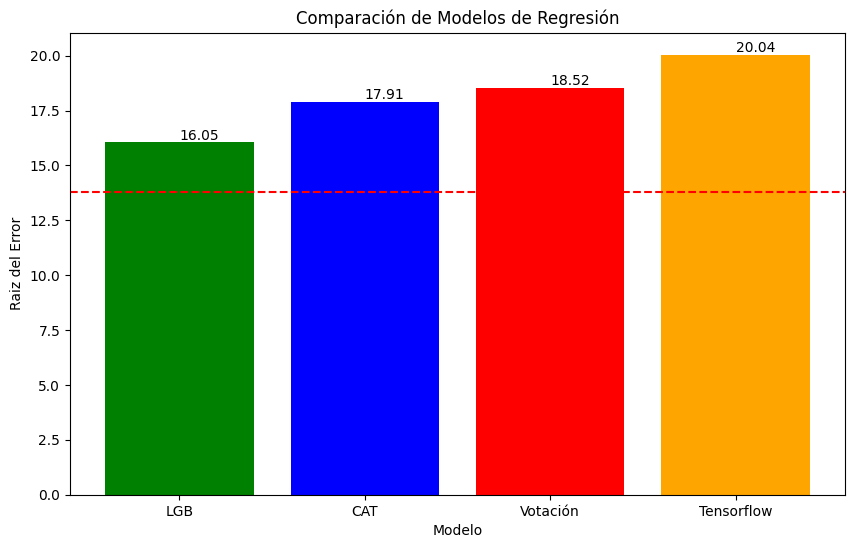

In [ ]:
# Comparar modelos de Regresion con el rmse gráficamente mediante barras
rmse = [lgb_rmse, cat_rmse, vot_rmse, tf_rmse]
modelos = ['LGB', 'CAT', 'Votación', 'Tensorflow']
plt.figure(figsize=(10, 6))
bars = plt.bar(modelos, rmse, color=['green', 'blue', 'red', 'orange'])
plt.title('Comparación de Modelos de Regresión')
plt.xlabel('Modelo')
plt.ylabel('Raiz del Error')

# Añadir el valor de cada barra en la gráfica
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), va='bottom')  # va: vertical alignment

# La mejor metrica del bootcamp
plt.axhline(y=13.78, color='r', linestyle='--')

plt.show()

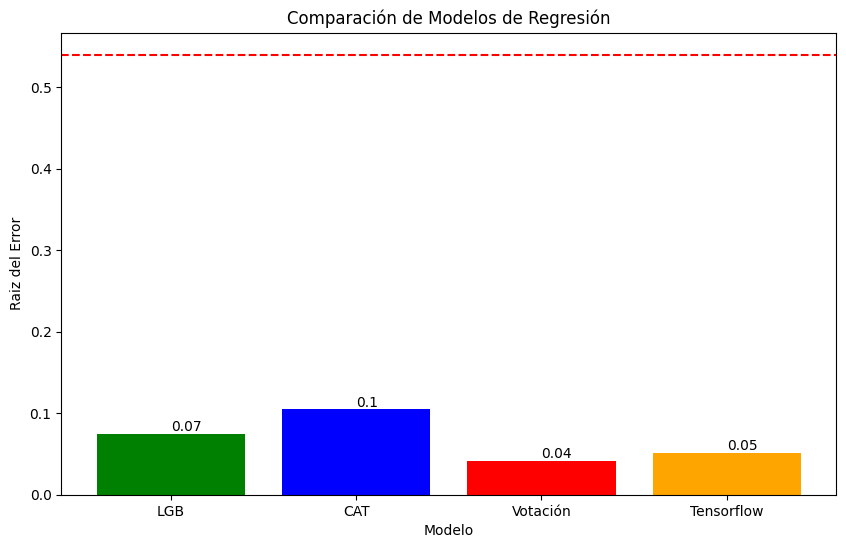

In [ ]:
# Comparar modelos de Regresion con el r2 gráficamente mediante barras
rmse = [lgb_r2_adj, cat_r2_adj, vot_r2_adj, r2_tf_adj]
modelos = ['LGB', 'CAT', 'Votación', 'Tensorflow']
plt.figure(figsize=(10, 6))
bars = plt.bar(modelos, rmse, color=['green', 'blue', 'red', 'orange'])
plt.title('Comparación de Modelos de Regresión')
plt.xlabel('Modelo')
plt.ylabel('Raiz del Error')

# Añadir el valor de cada barra en la gráfica
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), va='bottom')  # va: vertical alignment

# La mejor metrica del bootcamp
plt.axhline(y=0.54, color='r', linestyle='--')

plt.show()

---
---